# **ThermalTimelapse: thermal infrared (TIR) correction to derive surface temperature ($T_s$) from oblique, in-field time-lapse thermal imagery**
 
This tool enables easy processing of thermal imagery free from commercial black box software. The tool solves for unique environmental parameters for each image in a time-series and corrects for different object distances within one scene and different atmospheric composition when looking over glacier ice or snow versus rock or vegetated land that does not generally develop katabatic winds. The tool uses standard atmospheric equations rather than an unknown algorithm from on camera processing or commercial/proprietary software post processing. The tool also automatically co-registers images in a time-series to correct for camera movement on a potentially unstable surface.  

The thermal correction is based on [Tattersall, 2019](https://CRAN.R-project.org/package=Thermimage), [gaussorgues, 1994](https://link.springer.com/chapter/10.1007/978-94-011-0711-2_3) and [Usamentiaga, 2014](https://www.mdpi.com/1424-8220/14/7/12305/pdf). Images are automatically co-registered (rotation, translation and scale or rotation and translation only) using [imreg_dft by Týč and Gohlke](https://pypi.org/project/imreg_dft/#id1)) to correct for camera movement during time-lapse acquisition.

**Input data:**

- FLIR thermal .jpg image (camera parameters settings used during acquisition are irrelevant and will be overwritten/corrected)
- Local air temperature and relative humidity (RH) timeseries coincident with thermal image time-series (optional: precipitation data as an accommodating plot)
- A manually drawn .shp segmentation of the time-series frame where the thermal scene is subdivided into segments of similar surface type (emissivities) and distance from sensor. Each segment needs to be accompanied by an emissivity value, distance from sensor and fraction of rock versus glacier ice surface along the distance from sensor.   

This tool makes use of Jupyter's platform agnostic functionality and draws on tools in both R and Python.

**Required packages:** 

**R**

[Thermimage](https://github.com/gtatters/Thermimage) (code to install is included below)  
[exiftool](https://exiftool.org/) (install from link)  
fields (code to install is included below) 

**Python**

[imreg_dft](https://pypi.org/project/imreg_dft/)  
[PIL](https://pillow.readthedocs.io/en/stable/installation.html)  
imageio  
numpy  
datetime   
scipy  
matplotlib   
pandas


**Commercial Python package:**

[arcpy](https://www.esri.com/en-us/arcgis/products/arcgis-desktop/buy)*

*arcpy is non-essential and used for basic data manipulation and conversions. This package will be replaced with open-access tools in a future update.

**Setup directions**

- Install [Jupyterlab](https://jupyter.org/)
- Connect JupyterLab to Python 3 from ArcGIS Pro
- Add R from Python command prompt:
    - conda install -c r r-essentials
    - conda install -c anaconda jupyter_client

# The following code is in R

**Define paths to data:**

Directory to file containing subfiles for TIR images.

To support different co-registration parameters for different periods of image acquisition within one cumulative time-series (e.g. if a camera was more unstable for a particular span of time, or moved while changing a battery) the images can be broken into groups. Define the files containing each group here. Below, there will be additional input where the co-registration methods can be specified for each group. This also offers the ability to process only one block at a time. If there is no anticipated breaks, define only one subfolder. 

In [1]:
IRimage_dir = getwd() # or define a path, e.g.: "C:/Users/Sam/Desktop/ThermalTimelapse/CanwellGlacierTIR_2016/"

List of subfolders:

In [2]:
subfolders <- c("IR_10823toIR_10824","IR_11145toIR_11146") 

The code below uses Thermimage to covert the raw FLIR image values to temperature assuming perfect black body condition (Emissivity = 1, distance = 0) and the [FLIR coefficients specific to the thermal camera used](https://rdrr.io/cran/Thermimage/man/raw2temp.html). This temperature is then converted to radiance ($W_{tot}$, Wm$^{-2}$) using the Stefan–Boltzmann law:

$W_{tot}=\sigma T^4$

where T is thermal camera derived perfect black body temperature (K) and $\sigma$ is the Stefan-Boltzmann constant. 

If Thermimage is not yet installed run:

In [ ]:
install.packages("Thermimage", repos='http://cran.us.r-project.org')

If "fields" is not yet installed run:

In [ ]:
install.packages("fields")

Warning message in file.remove("tempfile"):
"cannot remove file 'tempfile', reason 'Permission denied'"

[1] "If this image needs to be rotated, specifify how in the python code below."


Warning message in file.remove("tempfile"):
"cannot remove file 'tempfile', reason 'Permission denied'"Warning message in file.remove("tempfile"):
"cannot remove file 'tempfile', reason 'Permission denied'"

[1] "If this image needs to be rotated, specifify how in the python code below."


Warning message in file.remove("tempfile"):
"cannot remove file 'tempfile', reason 'Permission denied'"

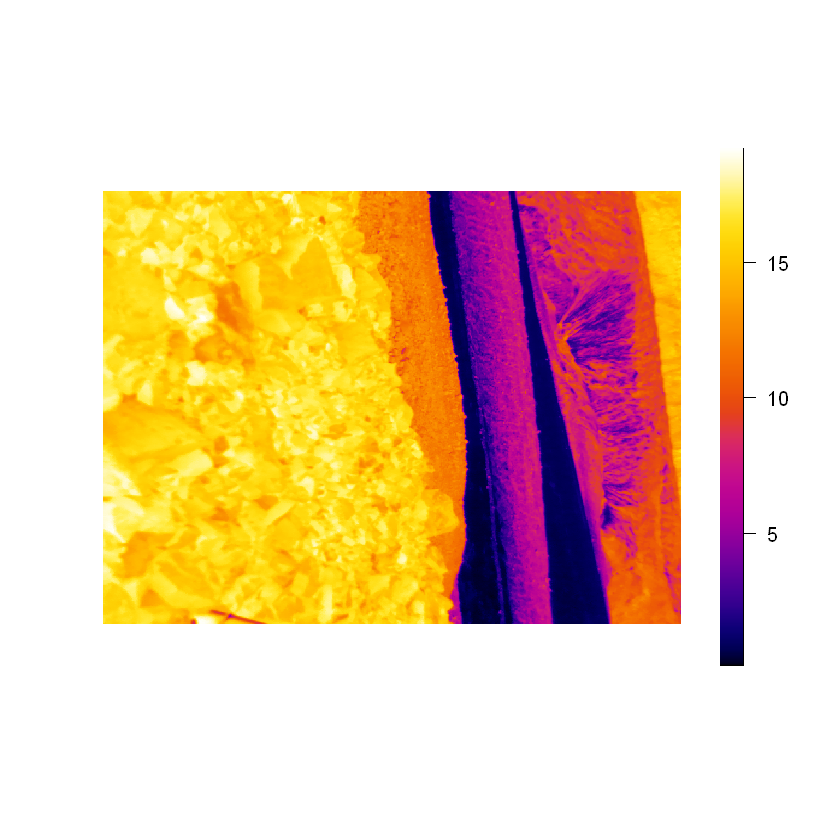

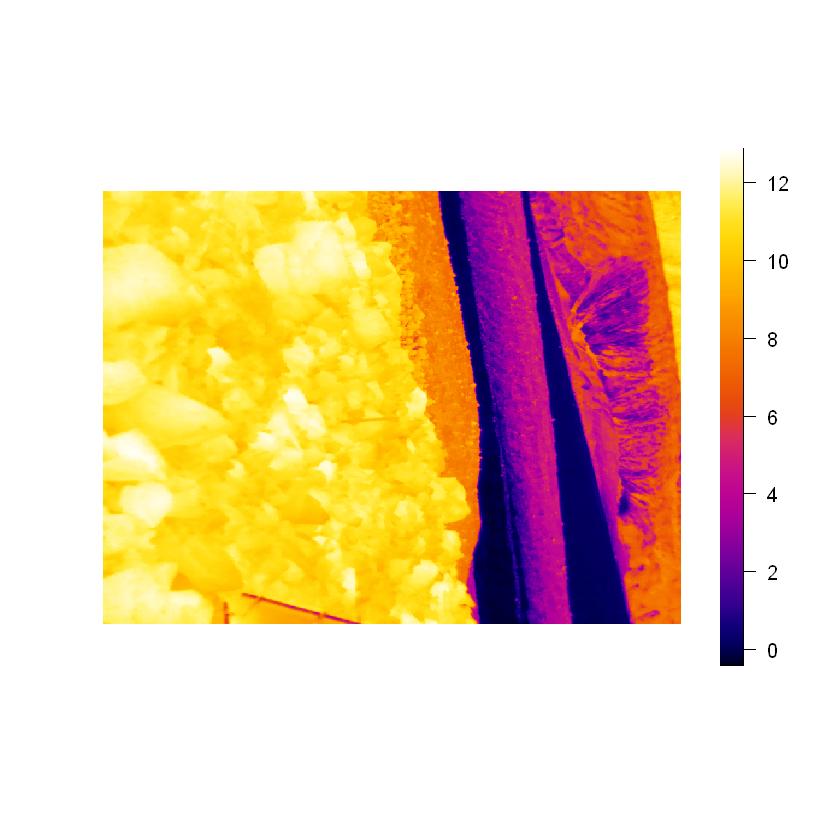

In [4]:
library(Thermimage)
for (sub in subfolders) {
IRimage_dir_sub = paste0(IRimage_dir,"/",sub)
resultFolder = paste0(getwd(),"/Results_",sub)
dir.create(resultFolder) # Create results folder
files <- list.files(path=IRimage_dir_sub, pattern=".jpg", all.files=T, full.names=T)
for (file in files) {
f<-paste0(file)
img<-readflirJPG(f, exiftoolpath="installed")
cams<-flirsettings(f, exiftoolpath="installed", camvals="")
plancks<-flirsettings(f, exiftoolpath="installed", camvals="-*Planck*")
    
# get image parameters
ObjectEmissivity<-  cams$Info$Emissivity              # Image Saved Emissivity - should be ~0.95 or 0.96
dateOriginal<-cams$Dates$DateTimeOriginal             # Original date/time extracted from file
dateAcquisition<-cams$Dates$CreateDate                # Acquisition date/time extracted from file
dateModif<-   cams$Dates$FileModificationDateTime     # Modification date/time extracted from file
PlanckR1<-    cams$Info$PlanckR1                      # Planck R1 constant for camera  
PlanckB<-     cams$Info$PlanckB                       # Planck B constant for camera  
PlanckF<-     cams$Info$PlanckF                       # Planck F constant for camera
PlanckO<-     cams$Info$PlanckO                       # Planck O constant for camera
PlanckR2<-    cams$Info$PlanckR2                      # Planck R2 constant for camera
ATA1<-        cams$Info$AtmosphericTransAlpha1        # Atmospheric Transmittance Alpha 1
ATA2<-        cams$Info$AtmosphericTransAlpha2        # Atmospheric Transmittance Alpha 2
ATB1<-        cams$Info$AtmosphericTransBeta1         # Atmospheric Transmittance Beta 1
ATB2<-        cams$Info$AtmosphericTransBeta2         # Atmospheric Transmittance Beta 2
ATX<-         cams$Info$AtmosphericTransX             # Atmospheric Transmittance X
OD<-          cams$Info$ObjectDistance                # object distance in metres
FD<-          cams$Info$FocusDistance                 # focus distance in metres
ReflT<-       cams$Info$ReflectedApparentTemperature  # Reflected apparent temperature
AtmosT<-      cams$Info$AtmosphericTemperature        # Atmospheric temperature
IRWinT<-      cams$Info$IRWindowTemperature           # IR Window Temperature
IRWinTran<-   cams$Info$IRWindowTransmission          # IR Window transparency
RH<-          cams$Info$RelativeHumidity              # Relative Humidity
h<-           cams$Info$RawThermalImageHeight         # sensor height (i.e. image height)
w<-           cams$Info$RawThermalImageWidth          # sensor width (i.e. image width)

# convert raw values to temperature in perfect black body conditions 
temperature<-raw2temp(img, 1, 0, ReflT, AtmosT, IRWinT, IRWinTran, RH,
                      PlanckR1, PlanckB, PlanckF, PlanckO, PlanckR2, 
                      ATA1, ATA2, ATB1, ATB2, ATX)
file.remove('tempfile')
radiation<-5.67*10**(-8) * (temperature+273.15)**4 # Stefan–Boltzmann law

library(lubridate)
correct_timeStamp<-ymd_hms((paste(dateAcquisition,"-04")))
dateAcquisition
correct_timeStamp
y<-substr(correct_timeStamp,1,4)
mo<-substr(correct_timeStamp,6,7)
d<-substr(correct_timeStamp,9,10)
hr<-substr(correct_timeStamp,12,13)
min<-substr(correct_timeStamp,15,16)
s<-substr(correct_timeStamp,18,19)

#get file name and write .csv
fileName<-gsub("^.*/", "", file)
fileName<-tools::file_path_sans_ext(fileName)
dateName<-paste(fileName,"_BBradiance_y",y,"mo",mo,"d",d,"hr",hr,"min",min,"s",s,".csv")
dateName<-gsub(" ", "",dateName)
write.csv(radiation,paste0(resultFolder,"/",dateName))

if(file == files[1]){ # Plot first image in stack
library(fields) # should be imported when installing Thermimage
plotTherm(temperature, w=w, h=h, minrangeset = min(temperature), maxrangeset = max(temperature))
print ("If this image needs to be rotated, specifify how in the python code below.")
}
}
}

# The following code is in Python

In [1]:
import os
import numpy as np
import csv
from datetime import datetime, date, time
from PIL import Image
import imageio
from scipy.integrate import simps
import imreg_dft as ird
import numpy as np
import arcpy
arcpy.CheckOutExtension('Spatial')
from arcpy import env
from arcpy.sa import ExtractByMask, Raster
import matplotlib.pyplot as plt
import pandas as pd

Get black body radiance image folders from R code above:

In [2]:
files = []
dir_path = os.path.abspath(os.getcwd())
for file in os.listdir():
    if file.startswith("Results"):
        files.append( dir_path + "\\" + file )

List image acquisition window subfolders:

In [3]:
for i in enumerate(files):
    print(str(i[0]+1)+". "+i[1].split("\\")[-1])

1. Results_IR_10823toIR_10824
2. Results_IR_11145toIR_11146


For each image subfolder, specify whether or not to apply scaling in addition to rotation and translation. 

The algorithm will automatically rotate/translate each image to match the previous in the series. If scaleToo == 'y' for an image acquisition window subfolder, it will also use scaling parameters to shrink or enlarge the image to get a higher correlation with the previous image. This may be undesirable if it causes excessive image distortion and can be turned off with scaleToo = 'n'. To make this choice, try running without scaling and consider the success rate metric printed for each image pair. If the value(s) are consistently low, see if they improve by including scaling.  

In [4]:
scaleToo = ['n','n'] # for each time window, needs to have the same length (and same order) as the list above

Path to original files and segmentation folder.

In this path, have an image folder(s) and a second folder(s) with the same name as the image folder followed by "_segmentation" with manually defined segmetns where you want discrete atmospheric solutions. 

In [5]:
IRimage_dir = os.getcwd() # or define a different path 

Based on the plotted image from R above, set the number (0,1,2 or 3) of 90° rotations (clockwise) needed to get the image right-side-up.

In [6]:
n_rorations = 2

(Optional) To test and plot the rotation on the first image, run the next block of code:

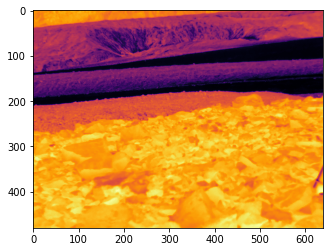

In [7]:
img_csv = []
imglist = os.listdir(files[0])
for img in imglist:
    if img.lower().endswith(".csv"):
        img_csv.append(img)
IRdata = []
IRdata = np.genfromtxt(files[0]+"\\"+img_csv[0],delimiter=",", skip_header=1,usecols=np.arange(0,641))

IRdata = np.delete(IRdata, 0, 1)
IRdata = np.rot90(IRdata, n_rorations)

plt.imshow(IRdata,cmap="inferno")

Assign path to air temperature ($T_a$) and relative humidity (RH) data that overlap in time with the thermal images defined above. Data format accommodates raw (.csv) [Hobo U23 Pro v2](https://www.onsetcomp.com/products/data-loggers/u23-001a) data. 

In [8]:
Ta_RH = r"CanwellGlacierMetStation_2016\1_Deb_air.csv"

Optional precipitation data. Set to "Precip = []" if no data. Data interval set to 15 minutes but can be changed below.

In [9]:
Precip = r"CanwellGlacierMetStation_2016\TB.csv"

Load met data:

In [10]:
with open(Ta_RH) as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    next(readCSV, None)
    next(readCSV, None)
    Tdate = []
    Ta = []
    RH = []
    for row in readCSV:
        Tdate.append(datetime.datetime.strptime(row[1], '%m/%d/%y %I:%M:%S %p'))
        Ta.append(row[2])
        RH.append(row[3])
del readCSV

In [11]:
# Load precip data
if not Precip == []:
    with open(Precip) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        next(readCSV, None)
        next(readCSV, None)
        TBdate = []
        TB = []
        for row in readCSV:
            TBdate.append(datetime.datetime.strptime(row[1], '%m/%d/%y %I:%M:%S %p'))
            TB.append(row[2])
    del readCSV
    #convert tipping bucket count to rate
    ts = pd.Series(np.random.randint(0, 1, len(TBdate)), index=TBdate)
    TBr = ts.resample('15Min').count()
    TBmmPer15Min = TBr*0.2 # correction factor for Hobo

If there is an aparent or known linear offset in the thermal data, e.g. bare glacier ice with nearly no impurities showing a consistent surface temperature > or < 0°C while air temperature is $\gg$0°C, it can be corrected for below: 

In [12]:
linear_Ts_correction = 0 # in °C

Set emissivity of debris cover and bare ice: 

In [13]:
emis_deb = 0.94
emis_ice = 0.97

The loop below iterates over each thermal image solving for $T_s$. Discrete atmospheric variables are applied to each image segment and image rotation, translation and optional scaling is applied. An output .cvs returns mean, median and percentile statistics (10, 33, 66 and 90%) for each image segment.

IR image date:          Monday 01 August 2016 02:27PM
Closest Ta and RH date:  Monday 01 August 2016 02:30PM
Image Ir_10823 is shifted and corrected. Processing successful.
IR image date:          Monday 01 August 2016 02:42PM
Closest Ta and RH date:  Monday 01 August 2016 02:40PM


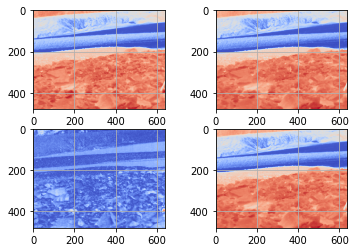

Translation is (-0.0096, 0.0326), success rate 0.9064
Image Ir_10824 is shifted and corrected. Processing successful.
IR image date:          Thursday 11 August 2016 03:47PM
Closest Ta and RH date:  Thursday 11 August 2016 03:50PM
Image Ir_11145 is shifted and corrected. Processing successful.
IR image date:          Thursday 11 August 2016 04:02PM
Closest Ta and RH date:  Thursday 11 August 2016 04:00PM


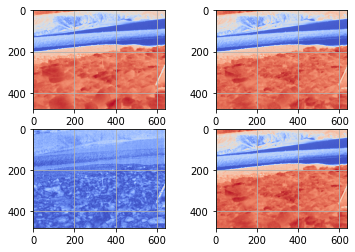

Translation is (-0.2544, -0.0944), success rate 0.8625
Image Ir_11146 is shifted and corrected. Processing successful.


In [14]:
timeWindow_count = 0
for img_dir in files:
    
    arcpy.env.workspace = img_dir
    dirlist=os.listdir(img_dir)
    
    img_range = img_dir.split("\\")[-1]
    
    #list of images that contain the black body radiance images from R code above
    img_csv=[]
    for item in dirlist:
        if item.lower().endswith(".csv"):
                img_csv.append(item)

    # iterate over thermal images
    timelapseMeans = []
    count = 0
    for IRTimage in img_csv:
        
        # thermal data as a numpy array
        IRdata = []
        IRdata = np.genfromtxt(img_dir+"\\"+IRTimage,delimiter=",", skip_header=1,usecols=np.arange(0,641))
        
        IRdata = np.delete(IRdata, 0, 1)
        
        ## remove odd row of nans... this is lilely specific to the example data and can be commented out for other applications. 
        if len(IRdata[1,:]) == 641:
            IRdata = np.delete(IRdata, 640, 1)
        
        # flip/ rotate image by specified number of 90 degree rotations, defined above
        IRdata = np.rot90(IRdata, n_rorations)
        
        # date and time of thermal image in DateTime format        
        year = IRTimage.split("_y")[1][0:4]
        month = IRTimage.split("_y")[1][6:8]
        day = IRTimage.split("_y")[1][9:11]
        hour = IRTimage.split("_y")[1][13:15]
        minute = IRTimage.split("_y")[1][18:20] 
 
        d = []
        t = []
        dt = []
        d = date(int(year),int(month),int(day))
        
        t = datetime.time(int(hour),int(minute))
        dt = datetime.datetime.combine(d, t)
        print('IR image date:          '+dt.strftime("%A %d %B %Y %I:%M%p"))
        
        # find closest met station data (the data aquisiton interval can be different and not exactly overlapping, 
        # however, a big $dt$, e.g. an hour or more, will likely return less accurate results)
        
        metdate = min(Tdate, key=lambda d: abs(d - dt))
        
        print ('Closest Ta and RH date:  '+metdate.strftime("%A %d %B %Y %I:%M%p"))
        
        near_Ta = float(Ta[Tdate.index(metdate)]) # index from metdate
        near_RH = float(RH[Tdate.index(metdate)]) # index from metdate
        
        # organize data to print to time-lapse file and make figures
        img_data = []
        img_data = [metdate,near_Ta, near_RH, dt]
        
        # Time-of-day correction factors for near-surface atmosphere above bare ice from near-surface atmosphere above debris cover. 
        # These values were derived at Canwell Glacier, Alaska, USA in 2012 (see Herreid, 2021)
        temp_correction_hr = [2.3203, 2.1161, 2.0577, 1.7154, 1.7480, 1.3463, 1.4087, 1.3058, 1.4303, 1.4741, 1.7397, 2.1623, 1.8717, 2.1405, 2.7771, 2.9058, 2.8852, 2.5368, 2.5236, 2.4376, 2.6815, 2.4864, 2.4259, 2.3775]
        RH_correction_hr = [-6.6204, -6.2522, -6.0291, -5.3188, -5.8662, -4.6789, -4.4547, -3.6908, -4.4954, -5.2715, -5.6277, -7.1749, -6.1868, -7.5477, -9.3757, -9.8619, -9.7594, -8.3869, -8.5479, -7.6599, -8.2420, -8.1545, -7.4854, -6.7044]
        
        near_Ta_ice =  near_Ta - temp_correction_hr[int(metdate.hour)]
        near_RH_ice =  near_RH - RH_correction_hr[int(metdate.hour)]
        
        # coregister spatially the IR image with the previous (in time) IR image
              
        if count != 0:
    
            # template image
            imgNumber = []
            imgNumber = IRTimage[3:8]
            imgBefore = img_csv[count-1][3:8]
            #im0 = sp.misc.imread(os.path.join(img_dir, "Ir_"+str(imgBefore)+".tif"), True)
            im0 = imageio.imread(os.path.join(img_dir, "Ir_"+str(imgBefore)+".tif"))
            
            # the image to be transformed            
            img = []
            img = Image.fromarray(IRdata)  
            img.save(img_dir+"\\"+"del_tempIr"+str(int(imgNumber))+".tif")
            im1 = imageio.imread(os.path.join(img_dir, "del_tempIr"+str(int(imgNumber))+".tif"))
    
            # rotation and scale -----------------------
            
            if scaleToo[timeWindow_count] == 'y':
                result = ird.similarity(im0, im1, numiter=3)
                
                assert "timg" in result
                if os.environ.get("IMSHOW", "yes") == "yes":
                    ird.imshow(im0, im1, result['timg'])
                    plt.show()
                resultIR = Image.fromarray(result['timg'])
                resultIR.save(img_dir+"\\"+"Ir_"+str(int(imgNumber))+".tif")
    
            # rotation only ---------------------------- 
            if scaleToo[timeWindow_count] == 'n':
                result = ird.translation(im0, im1)
                tvec = result["tvec"].round(4)
                # the transformed image.
                timg = ird.transform_img(im1, tvec=tvec)
                
                if os.environ.get("IMSHOW", "yes") == "yes":
                    ird.imshow(im0, im1, timg)
                    plt.show()
                
                print("Translation is {}, success rate {:.4g}"
                      .format(tuple(tvec), result["success"]))            
                     
                resultIR = Image.fromarray(timg)
                resultIR.save(img_dir+"\\"+"Ir_"+str(int(imgNumber))+".tif")
            
            # ------------------------------------------
            
            os.remove(img_dir+"\\"+"del_tempIr"+str(int(imgNumber))+".tif")
                
        else:
            #save first image as an image with correct path
            imgNumber = IRTimage[3:8]
            img = []
            img = Image.fromarray(IRdata)  
            img.save(img_dir+"\\Ir_"+str(int(imgNumber))+".tif")
        count += 1
        
        # convert to ArcGIS rasrter 
    
        if 'resultIR' in locals():
            # translate and scale
            if scaleToo[timeWindow_count] == 'y':
                np.savetxt(img_dir+"\\"+"Ir_"+str(int(imgNumber))+"shifted.txt", result['timg'], fmt='%1.3f',comments='', delimiter=" ", header='NCOLS 640\nNROWS 480\nXLLCORNER 0\nYLLCORNER 0\nCELLSIZE 1\nNODATA_VALUE -9999') 
    
            # translate only
            if scaleToo[timeWindow_count] == 'n':
                np.savetxt(img_dir+"\\"+"Ir_"+str(int(imgNumber))+"shifted.txt", timg, fmt='%1.3f',comments='', delimiter=" ", header='NCOLS 640\nNROWS 480\nXLLCORNER 0\nYLLCORNER 0\nCELLSIZE 1\nNODATA_VALUE -9999')
            del resultIR 
        else:
            np.savetxt(img_dir+"\\"+"Ir_"+str(int(imgNumber))+"shifted.txt", IRdata, fmt='%1.3f',comments='', delimiter=" ", header='NCOLS 640\nNROWS 480\nXLLCORNER 0\nYLLCORNER 0\nCELLSIZE 1\nNODATA_VALUE -9999') 
    
        if os.path.exists(img_dir+"\\"+"Ir_"+str(int(imgNumber))+"shifted.TIF"):
            os.remove(img_dir+"\\"+"Ir_"+str(int(imgNumber))+"shifted.TIF")
            arcpy.ASCIIToRaster_conversion(img_dir+"\\"+"Ir_"+str(int(imgNumber))+"shifted.txt", "Ir_"+str(int(imgNumber))+"shifted.TIF", "FLOAT")    
        else:
            arcpy.ASCIIToRaster_conversion(img_dir+"\\"+"Ir_"+str(int(imgNumber))+"shifted.txt", "Ir_"+str(int(imgNumber))+"shifted.TIF", "FLOAT")   
        
        # get path to segmentation files
        
        thisImageRange = str(img_dir).split("\\")[-1].split("Results_")[-1]
        thisSegmentation = IRimage_dir + "\\" + thisImageRange + "_segmentation"
        
        # Project each segmentation shape and thermal image into an arbitrary coordinate system so that there is a spatial reference
        # WGS_1984_UTM_Zone_6N
        # WKID: 32606 Authority: EPSG

        sr = arcpy.SpatialReference(32606)
        
        arcpy.DefineProjection_management(img_dir+"\\"+"Ir_"+str(int(imgNumber))+"shifted.TIF", sr)
        
        # this is currently hard coded, in a future fix this will be a loop
        arcpy.DefineProjection_management(thisSegmentation+"\\debris10.shp", sr)
        arcpy.DefineProjection_management(thisSegmentation+"\\debris112.shp", sr)
        arcpy.DefineProjection_management(thisSegmentation+"\\debris275.shp", sr)
        arcpy.DefineProjection_management(thisSegmentation+"\\debris620.shp", sr)
        arcpy.DefineProjection_management(thisSegmentation+"\\ice225.shp", sr)
        arcpy.DefineProjection_management(thisSegmentation+"\\ice488.shp", sr)
        arcpy.DefineProjection_management(thisSegmentation+"\\valley1000.shp", sr)

        # extract IRT area within distance segmentation regions
        
        # this is currently hard coded, in a future fix this will be a loop
        arcpy.env.snapRaster = img_dir+"\\"+"Ir_"+str(int(imgNumber))+"shifted.TIF"
        
        outExtractByMask = ExtractByMask(img_dir+"\\"+"Ir_"+str(int(imgNumber))+"shifted.TIF", thisSegmentation+"\\debris10.shp")
        try:
            outExtractByMask.save(img_dir + "\\del_debris10.TIF")
        except:
            outExtractByMask.save(img_dir + "\\del_debris10.TIF")
        del outExtractByMask
        outExtractByMask = ExtractByMask(img_dir+"\\"+"Ir_"+str(int(imgNumber))+"shifted.TIF", thisSegmentation+"\\debris112.shp")
        try:
            outExtractByMask.save(img_dir + "\\del_debris112.TIF")
        except:
            outExtractByMask.save(img_dir + "\\del_debris112.TIF")    
        del outExtractByMask
        outExtractByMask = ExtractByMask(img_dir+"\\"+"Ir_"+str(int(imgNumber))+"shifted.TIF", thisSegmentation+"\\debris275.shp")
        try:    
            outExtractByMask.save(img_dir + "\\del_debris275.TIF")
        except:
            outExtractByMask.save(img_dir + "\\del_debris275.TIF")
        del outExtractByMask
        outExtractByMask = ExtractByMask(img_dir+"\\"+"Ir_"+str(int(imgNumber))+"shifted.TIF", thisSegmentation+"\\debris620.shp")
        try:
            outExtractByMask.save(img_dir + "\\del_debris620.TIF")
        except:
            outExtractByMask.save(img_dir + "\\del_debris620.TIF")
        del outExtractByMask
        outExtractByMask = ExtractByMask(img_dir+"\\"+"Ir_"+str(int(imgNumber))+"shifted.TIF", thisSegmentation+"\\ice225.shp")
        try:
            outExtractByMask.save(img_dir + "\\del_ice225.TIF")
        except:
            outExtractByMask.save(img_dir + "\\del_ice225.TIF")
        del outExtractByMask
        outExtractByMask = ExtractByMask(img_dir+"\\"+"Ir_"+str(int(imgNumber))+"shifted.TIF", thisSegmentation+"\\ice488.shp")
        try:
            outExtractByMask.save(img_dir + "\\del_ice488.TIF")
        except:
            outExtractByMask.save(img_dir + "\\del_ice488.TIF")
        del outExtractByMask
        outExtractByMask = ExtractByMask(img_dir+"\\"+"Ir_"+str(int(imgNumber))+"shifted.TIF", thisSegmentation+"\\valley1000.shp")
        try:
            outExtractByMask.save(img_dir + "\\del_valley1000.TIF")
        except:
            outExtractByMask.save(img_dir + "\\del_valley1000.TIF")
        del outExtractByMask
        # reflected temp from aluminum pole
        outExtractByMask = ExtractByMask(img_dir+"\\"+"Ir_"+str(int(imgNumber))+"shifted.TIF", thisSegmentation+"\\T_refl.shp")
        try:
            outExtractByMask.save(img_dir + "\\del_T_refl.TIF")
        except:
            outExtractByMask.save(img_dir + "\\del_T_refl.TIF")
        arcpy.RasterToFloat_conversion(img_dir + "\\del_T_refl.TIF", img_dir + "\\del_T_refl.flt")
        W_refl = Raster(img_dir + "\\del_T_refl.flt")
        
        T_refl = ((W_refl)/(5.67*10**(-8)))**(1/4)
        T_refl = float(str(arcpy.GetRasterProperties_management(T_refl, "MEAN")))
        del W_refl
        #T_refl = near_Ta + 273.15
        T_refl_ice = 273.15
        
        segment_count = 0
        # mean, median and percentile statistics for each segment will be written to image_means
        image_means = []
        
        #distances
        # this is currently hard coded, in a future fix this will be a loop
        x = [10, 112, 250, 620, 225, 460, 1060] # in meters
        ice_fract = [0, 0, 0.24, 0.55, 0.17, 0.44, 0.20] # along line of sight, see Herreid (2021), Fig. 1 
        segments = [img_dir + "\\del_debris10.TIF",img_dir + "\\del_debris112.TIF",img_dir + "\\del_debris275.TIF",img_dir + "\\del_debris620.TIF",img_dir + "\\del_ice225.TIF",img_dir + "\\del_ice488.TIF",img_dir + "\\del_valley1000.TIF"]
        
        for segment in segments:
            e_s_deb = 6.11*np.exp((17.625*(near_Ta))/((near_Ta)+243.04))
            e_s_ice = 6.11*np.exp((17.625*(near_Ta_ice))/((near_Ta_ice)+243.04))
            
            e_deb = e_s_deb*near_RH
            e_ice = e_s_ice*near_RH_ice
            
            #Atmospheric pressure, correct for you local setting!
            p = 87000 # from Kestral data collected in-field, Canwell Glacier, Alaska, USA, 2016 just before helicopter flight, 870 mb converted to Pa, see Herreid and Pellicciotti (2018) and Herreid (2021)
            
            # See Herreid (2021) for full description of methods, equations and units below
            
            w_deb = (e_deb*287.058)/(461.5*(p-e_deb)) 
            w_ice = (e_ice*287.058)/(461.5*(p-e_ice)) 
            
            qv_deb = w_deb/(w_deb+1)
            qv_ice = w_ice/(w_ice+1)
            
            rho_deb = (p/(287.058*(near_Ta+273.15)))*(1-(0.378*(e_deb/p)))
            rho_ice = (p/(287.058*(near_Ta_ice+273.15)))*(1-(0.378*(e_ice/p)))
            
            x_deb = x[segment_count]*(1-ice_fract[segment_count])
            x_ice = x[segment_count]*(ice_fract[segment_count]) 
            
            h = qv_ice*rho_ice*x_ice + qv_deb*rho_deb*x_deb 
            
            t_h2o = 0.95*np.exp(-0.019*h)+0.036
            
            t_co2 = 0.12*np.exp(-0.001*x[segment_count]) + 0.88*np.exp(-1e-05*x[segment_count])
            
            
            wav = [7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13,13.5,14]
            ta_s = []
            for wa in wav:
                s = np.exp(-((0.0002)*(0.6/wa)**1.3)*x[segment_count])
                ta_s.append(s)
            
            t_scat = simps(ta_s, dx=1/13)
            
            t_m = t_h2o * t_co2
            
            t_atm = t_m * t_scat
            
            arcpy.RasterToFloat_conversion(segment, segment.split("\\")[-1].split(".")[0]+".flt")
            W_tot = Raster(segment.split("\\")[-1].split(".")[0]+".flt")
            
            # solve for surface temperature over debris
            if segment.split("\\")[-1][4] == 'd': 
            
                T_s = ((W_tot - (1-emis_deb) * t_atm * 5.67*10**(-8) * (T_refl)**4 - (1 - t_atm) * 5.67*10**(-8) * (near_Ta + 273.15)**4)/(emis_deb*t_atm*5.67*10**(-8)))**(1/4)
    
            elif segment.split("\\")[-1][4] == 'v': # same as for debris but this is the valley wall
            
                T_s = ((W_tot - (1-emis_deb) * t_atm * 5.67*10**(-8) * (T_refl)**4 - (1 - t_atm) * 5.67*10**(-8) * (near_Ta + 273.15)**4)/(emis_deb*t_atm*5.67*10**(-8)))**(1/4)
            
            # solve for surface temperature over ice
            elif segment.split("\\")[-1][4] == 'i':
            
                T_s = ((W_tot - (1-emis_ice) * t_atm * 5.67*10**(-8) * (T_refl_ice)**4 - (1 - t_atm) * 5.67*10**(-8) * (near_Ta_ice + 273.15)**4)/(emis_ice*t_atm*5.67*10**(-8)))**(1/4)
            
            else: 
                print ('something is wrong with segment names not in format "del_" + "debris" or "ice"')
            
            del W_tot # clear lock
            
            T_s = T_s - 273.15 # to °C
            T_s = T_s + linear_Ts_correction # linear camera calibation correction 
            
            arcpy.env.snapRaster = img_dir + "\\Ir_"+str(int(imgNumber))+"shifted.TIF"
            T_s.save(segment.split("\\")[-1].split(".")[0]+"corrected.TIF")
            
            # print segment value to file to extend to img_data and finally timelapse data
            T_s_mean = []
            T_s_mean = float(str(arcpy.GetRasterProperties_management(segment.split("\\")[-1].split(".")[0]+"corrected.TIF", "MEAN")))
            image_means.append(T_s_mean)
            
            # median and percentile statistics per segment 
            seg_array = []
            seg_90 = []
            seg_10 = []
            seg_66 = []
            seg_33 = []
            T_s_median = []
            seg_array = arcpy.RasterToNumPyArray(segment.split("\\")[-1].split(".")[0]+"corrected.TIF")
            #stray values to nan
            seg_array[(seg_array < -100)] = np.nan
            #remove nans
            seg_array = seg_array[np.logical_not(np.isnan(seg_array))]
            seg_90, seg_10 = np.percentile(seg_array, [90 ,10])
            seg_66, seg_33 = np.percentile(seg_array, [66 ,33])
            T_s_median = np.median(seg_array)
            
            image_means.append(T_s_median)
            image_means.append(seg_33)
            image_means.append(seg_66)
            image_means.append(seg_10)
            image_means.append(seg_90)
            
            segment_count += 1
        
        seg = []
        for segment in segments:
            seg.append(segment.split("\\")[-1].split(".")[0]+"corrected.TIF")
         
        seg = str(seg)
        seg = seg.replace("]","").replace("[","").replace(",",";").replace("'","")
        
        arcpy.env.snapRaster = img_dir + "\\Ir_"+str(int(imgNumber))+"shifted.TIF"
        arcpy.MosaicToNewRaster_management(seg, img_dir, "Ir_"+str(int(imgNumber))+"_ShiftCorrectedMosaic.TIF", "", "32_BIT_FLOAT", "", "1", "FIRST","FIRST")
        
        img_data.extend(image_means)
        if len(timelapseMeans) == 0:
            timelapseMeans = img_data
        else:
            timelapseMeans = np.vstack((timelapseMeans,img_data))
        
        rasterList = arcpy.ListRasters("*del*")
        for raster in rasterList:
            arcpy.Delete_management(raster)
        del raster
        del rasterList
    
        print ("Image Ir_"+str(int(imgNumber))+" is shifted and corrected. Processing successful.")
    
    # this .csv contains segment mean, medians and percentile statistics (10, 33, 66 and 90%), this can easily be changed above.
    with open(img_dir+'\\timelapseStatistics'+thisImageRange+'.csv','w') as outputfile:
        for row in timelapseMeans:
            wrtr = csv.writer(outputfile, delimiter=',', quotechar='"', lineterminator = '\n')
            #change row[1] to wherever your datetime is
            row[0] = row[0].strftime('%Y-%m-%d %H:%M')
            row[3] = row[3].strftime('%Y-%m-%d %H:%M')
            wrtr.writerow(row)
    timeWindow_count += 1